In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam # - Works
import random
from glob import glob
import seaborn as sns
from tensorflow.keras.losses import SparseCategoricalCrossentropy
import matplotlib.pyplot as plt
import matplotlib.image as img
import warnings

# Suppress TensorFlow GPU-related warnings and set log level
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Initialize CUDA libraries only once
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    print("Memory growth settings adjusted for all GPU devices.")
else:
    print("No GPU devices found.")


2024-04-25 21:33:49.564387: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-25 21:33:49.564496: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-25 21:33:49.733780: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Memory growth settings adjusted for all GPU devices.


In [2]:
! rm -rf /kaggle/working/data/

# Reading input data

In [3]:
train_data_dir = pathlib.Path("/kaggle/input/skincancer/Images/train")
test_data_dir = pathlib.Path("/kaggle/input/skincancer/Images/test")

# Counting images of training and testing 

In [4]:
image_count_train = len(list(train_data_dir.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(test_data_dir.glob('*/*.jpg')))
print(image_count_test)

2645
660


# Preparing Dataset

In [5]:
batch_size = 32
img_height = 180
img_width = 180
rnd_seed = 123
random.seed(rnd_seed)

In [6]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2645 files belonging to 2 classes.
Using 2116 files for training.


In [7]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 2645 files belonging to 2 classes.
Using 529 files for validation.


In [8]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  test_data_dir,
  validation_split=0.9,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 660 files belonging to 2 classes.
Using 594 files for validation.


In [9]:
class_names = train_ds.class_names
print(class_names)

['benign', 'malignant']


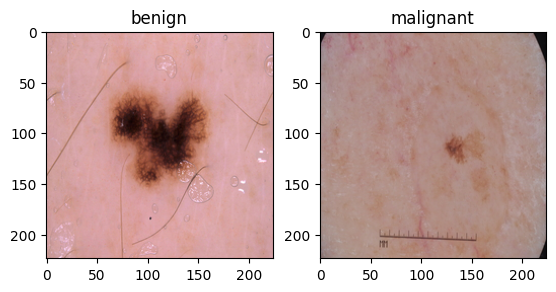

In [10]:
num_classes = len(class_names)
plt.figure(figsize=(10,10))
for i in range(num_classes):
  plt.subplot(3,3,i+1)
  image = img.imread(str(list(train_data_dir.glob(class_names[i]+'/*.jpg'))[1]))
  plt.title(class_names[i])
  plt.imshow(image)


In [11]:
for image_batch, labels_batch in train_ds.take(1):
    print(image_batch.shape)
    print(labels_batch.shape)

(32, 180, 180, 3)
(32,)


In [12]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Model 1 : simple 

In [13]:
model = tf.keras.Sequential([
    layers.Rescaling(1.0/255, input_shape=(img_height, img_width, 3)),
    Conv2D(32, 3, padding="same", activation='relu'),
    MaxPool2D(),
    Conv2D(64, 3, padding="same", activation='relu'),
    MaxPool2D(),
    Conv2D(128, 3, padding="same", activation='relu'),
    MaxPool2D(),
    Conv2D(256, 3, padding="same", activation='relu'),
    MaxPool2D(),
    Conv2D(512, 3, padding="same", activation='relu'),
    MaxPool2D(),
    Flatten(),
    Dense(1024, activation="relu"),
    Dense(units=num_classes, activation='softmax')  # Output layer with 2 units for binary classification
])

In [14]:
opt = Adam(learning_rate=0.001)  # Set learning rate using 'learning_rate' parameter
model.compile(optimizer=opt,
              loss=SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [15]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 180, 180, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 90, 90, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 90, 90, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 45, 45, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 45, 45, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 22, 22, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 22, 22, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 11, 11, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 11, 11, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 5, 5, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │    13,108,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │         2,050 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,678,850 (56.00 MB)

 Trainable params: 14,678,850 (56.00 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
epochs = 25
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/25
 3/67 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.4427 - loss: 1.1390  

I0000 00:00:1714080864.453106     116 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1714080864.472551     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


52/67 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 0.5137 - loss: 0.9532

W0000 00:00:1714080870.462485     117 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


66/67 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.5178 - loss: 0.9142

W0000 00:00:1714080872.325132     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


67/67 ━━━━━━━━━━━━━━━━━━━━ 26s 155ms/step - accuracy: 0.5184 - loss: 0.9096 - val_accuracy: 0.4726 - val_loss: 0.7797
Epoch 2/25
 3/67 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.5868 - loss: 0.7110

W0000 00:00:1714080874.743805     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.5786 - loss: 0.6778 - val_accuracy: 0.4480 - val_loss: 0.6971
Epoch 3/25
67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.5286 - loss: 0.6925 - val_accuracy: 0.7070 - val_loss: 0.5829
Epoch 4/25
67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.7397 - loss: 0.5637 - val_accuracy: 0.7996 - val_loss: 0.4740
Epoch 5/25
67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.7721 - loss: 0.4561 - val_accuracy: 0.5539 - val_loss: 1.0837
Epoch 6/25
67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.7485 - loss: 0.5670 - val_accuracy: 0.8147 - val_loss: 0.3942
Epoch 7/25
67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.7779 - loss: 0.4205 - val_accuracy: 0.8091 - val_loss: 0.4172
Epoch 8/25
67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.8023 - loss: 0.4101 - val_accuracy: 0.8393 - val_loss: 0.3564
Epoch 9/25
67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.8154 - loss: 0.3575 - val_accuracy: 0.8223 - val_loss: 0.

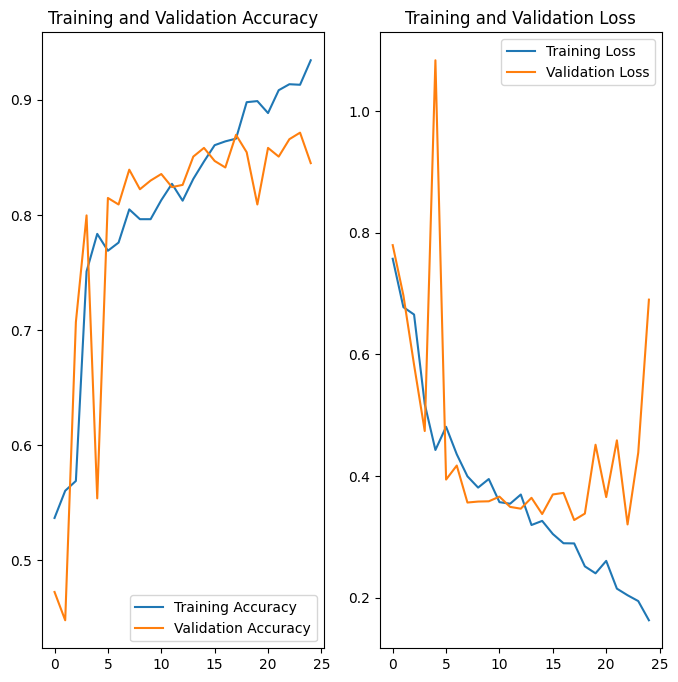

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Findings :
*   The model is behaving well but validation accuracy is low 

*   The training accuracy is just around 90-95 with 25 epochs and the model is yet to learn to many features.

*  data imbalance might be causing the bais to the model.

# Model 2 : Data Augumentation with drop out layer.

In [18]:
import tensorflow as tf
from tensorflow.keras import layers

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical", input_shape=(img_height, img_width, 3)),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
])


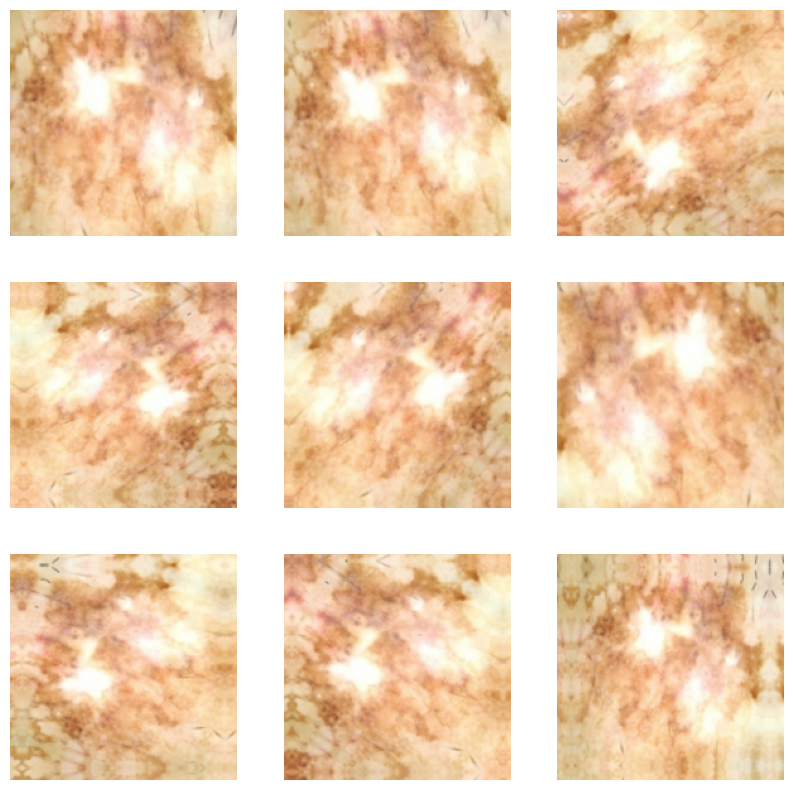

In [19]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")


In [20]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense


num_classes = 2
model = tf.keras.Sequential()

# Add data augmentation directly to the model
model.add(data_augmentation)

# Add Rescaling layer without using the experimental submodule
model.add(layers.Rescaling(1.0/255, input_shape=(img_height,img_width,3)))

# Continue with the rest of your model architecture
model.add(Conv2D(32, 3, padding="same", activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(64, 3, padding="same", activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(128, 3, padding="same", activation='relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.15))

model.add(Conv2D(256, 3, padding="same", activation='relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.20))

model.add(Conv2D(512, 3, padding="same", activation='relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(1024, activation="relu"))
model.add(Dense(units=num_classes, activation='softmax'))

In [21]:
opt = Adam(learning_rate=0.001)  # Set learning rate using 'learning_rate' parameter
model.compile(optimizer=opt,
              loss=SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [22]:
epochs = 25
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/25


2024-04-25 21:35:46.612177: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_2_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


67/67 ━━━━━━━━━━━━━━━━━━━━ 13s 99ms/step - accuracy: 0.5176 - loss: 0.8158 - val_accuracy: 0.5520 - val_loss: 0.6744
Epoch 2/25
67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 75ms/step - accuracy: 0.7082 - loss: 0.5646 - val_accuracy: 0.5917 - val_loss: 0.6276
Epoch 3/25
67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - accuracy: 0.7056 - loss: 0.5173 - val_accuracy: 0.7996 - val_loss: 0.4105
Epoch 4/25
67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - accuracy: 0.7991 - loss: 0.4133 - val_accuracy: 0.8091 - val_loss: 0.4029
Epoch 5/25
67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - accuracy: 0.7927 - loss: 0.4320 - val_accuracy: 0.8223 - val_loss: 0.3922
Epoch 6/25
67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - accuracy: 0.7886 - loss: 0.4400 - val_accuracy: 0.8242 - val_loss: 0.3992
Epoch 7/25
67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - accuracy: 0.7976 - loss: 0.4263 - val_accuracy: 0.8110 - val_loss: 0.4814
Epoch 8/25
67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - accuracy: 0.7650 - loss: 0.4578 - val_accuracy: 0.8053 - val_loss: 0

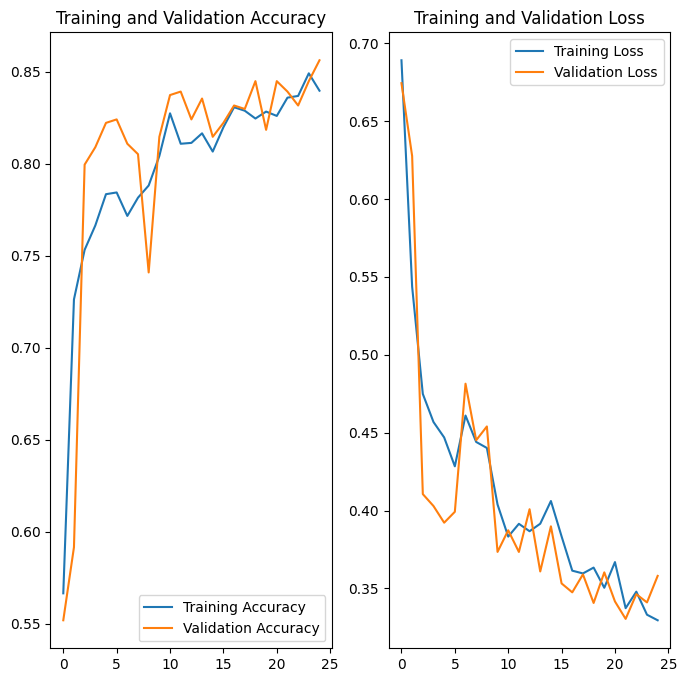

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Findings 
* With data agumenatation and dropout layer, the overfitting of the model is adressed to great extend. Earlier the train and validation accuracy difference was nearly about 5 to 10 %, with latest approach it's reduced to 2-4%. 

* The accuracy of the model is compromised heavily and decreased by fair bit from previous venilla model. 

* Considering above 2 points, there is still a scope of lot of improvement of the model.

# Analysing the class imbalance of the data

total training image count = 2645 

-------------------------------------
Class name =  benign
count      =  1440
proportion =  0.5444234404536862
-------------------------------------
Class name =  malignant
count      =  1205
proportion =  0.4555765595463138
-------------------------------------


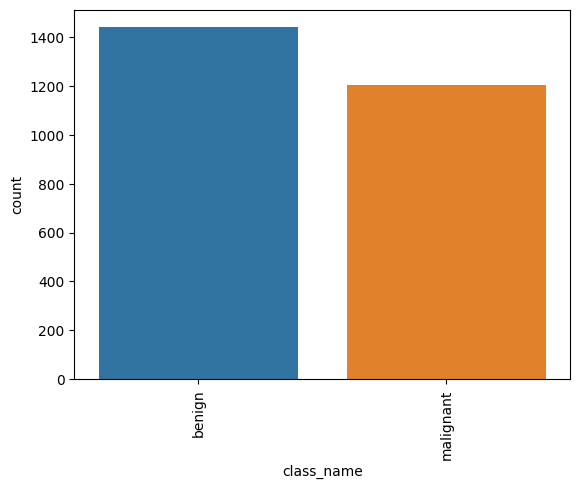

In [24]:
num_classes = len(class_names)
total = 0
all_count = []
class_name = []
for i in range(num_classes):
  count = len(list(train_data_dir.glob(class_names[i]+'/*.jpg')))
  total += count
print("total training image count = {} \n".format(total))
print("-------------------------------------")
for i in range(num_classes):
  count = len(list(train_data_dir.glob(class_names[i]+'/*.jpg')))
  print("Class name = ",class_names[i])
  print("count      = ",count)
  print("proportion = ",count/total)
  print("-------------------------------------")
  all_count.append(count)
  class_name.append(class_names[i])

temp_df = pd.DataFrame(list(zip(all_count, class_name)), columns = ['count', 'class_name'])
sns.barplot(data=temp_df, y="count", x="class_name")
plt.xticks(rotation=90)
plt.show()

## Findings 
Data is slightly imbalance and hence due to that results and predictions will be baised.

In [25]:
!pip install Augmentor

In [26]:
import Augmentor
# Define the path to the training dataset
path_to_training_dataset = '/kaggle/input/skincancer/Images/train'
# Loop through class names and create Augmentor pipelines
for class_name in class_names:
    # Define the output directory for Augmentor's processed images
    output_directory = '/kaggle/working/' + class_name + '/output'
    
    # Create an Augmentor pipeline for each class
    p = Augmentor.Pipeline(source_directory=os.path.join(path_to_training_dataset, class_name),
                            output_directory=output_directory)
    
    # Apply augmentation operations (e.g., rotation)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    
    # Generate augmented samples
    p.sample(1000)

Initialised with 1440 image(s) found.
Output directory set to /kaggle/working/benign/output.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x79DFBC31D150>: 100%|██████████| 1000/1000 [00:04<00:00, 231.21 Samples/s]                 


Initialised with 1205 image(s) found.
Output directory set to /kaggle/working/malignant/output.

Processing <PIL.Image.Image image mode=RGB size=224x224 at 0x79DFBC201A80>: 100%|██████████| 1000/1000 [00:03<00:00, 251.80 Samples/s]                 


In [27]:
output_dir = pathlib.Path('/kaggle/working/')
image_count_train = len(list(output_dir.glob('*/output/*.jpg')))
print(image_count_train)

2000


total training image count = 2000 

-------------------------------------
Class name =  benign
count      =  1000
proportion =  0.5
-------------------------------------
Class name =  malignant
count      =  1000
proportion =  0.5
-------------------------------------


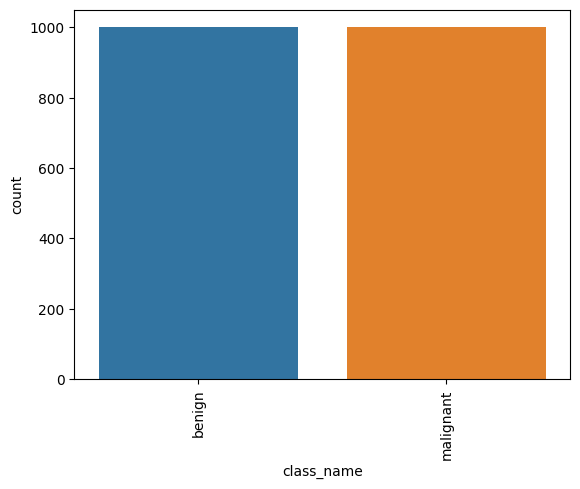

In [28]:
num_classes = len(class_names)
total = 0
all_count = []
class_name = []

for i in range(num_classes):
  count = len(list(output_dir.glob(class_names[i]+'/output/*.jpg')))
  total += count
print("total training image count = {} \n".format(total))
print("-------------------------------------")
for i in range(num_classes):
  count = len(list(output_dir.glob(class_names[i]+'/output/*.jpg')))
  print("Class name = ",class_names[i])
  print("count      = ",count)
  print("proportion = ",count/total)
  print("-------------------------------------")
  all_count.append(count)
  class_name.append(class_names[i])


temp_df = pd.DataFrame(list(zip(all_count, class_name)), columns = ['count', 'class_name'])
sns.barplot(data=temp_df, y="count", x="class_name")
plt.xticks(rotation=90)
plt.show()

# Model 3 : Model with Class balance data.

In [29]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  output_dir,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 2000 files belonging to 2 classes.
Using 1600 files for training.


In [30]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  output_dir,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 2000 files belonging to 2 classes.
Using 400 files for validation.


In [31]:
print(train_ds.class_names)

['benign', 'malignant']


In [32]:

from tensorflow.keras.layers import Rescaling  # Import Rescaling layer

num_classes = 2

model = Sequential([
    Rescaling(1.0/255, input_shape=(img_height, img_width, 3))
])

model.add(Conv2D(32, 3, padding="same", activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(64, 3, padding="same", activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(128, 3, padding="same", activation='relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.15))

model.add(Conv2D(256, 3, padding="same", activation='relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.20))

model.add(Conv2D(512, 3, padding="same", activation='relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(1024, activation="relu"))
model.add(Dense(units=num_classes, activation='softmax'))


In [33]:
opt = Adam(learning_rate=0.0001)  # Set learning rate using 'learning_rate' parameter
model.compile(optimizer=opt,
              loss=SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [34]:
epochs = 60
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/60
 3/50 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.4931 - loss: 0.7443

W0000 00:00:1714081107.393295     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.5060 - loss: 0.7169

W0000 00:00:1714081110.166238     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 101ms/step - accuracy: 0.5080 - loss: 0.7156 - val_accuracy: 0.7575 - val_loss: 0.5707
Epoch 2/60
 1/50 ━━━━━━━━━━━━━━━━━━━━ 6s 129ms/step - accuracy: 0.7188 - loss: 0.5808

W0000 00:00:1714081112.399274     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.7517 - loss: 0.5369 - val_accuracy: 0.7250 - val_loss: 0.5280
Epoch 3/60
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.7651 - loss: 0.5063 - val_accuracy: 0.8050 - val_loss: 0.4701
Epoch 4/60
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.7890 - loss: 0.4545 - val_accuracy: 0.7850 - val_loss: 0.4696
Epoch 5/60
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.7720 - loss: 0.4694 - val_accuracy: 0.8075 - val_loss: 0.4201
Epoch 6/60
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.8041 - loss: 0.4158 - val_accuracy: 0.8150 - val_loss: 0.3890
Epoch 7/60
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.8115 - loss: 0.4121 - val_accuracy: 0.8200 - val_loss: 0.3839
Epoch 8/60
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.8148 - loss: 0.3882 - val_accuracy: 0.8250 - val_loss: 0.3773
Epoch 9/60
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.8474 - loss: 0.3726 - val_accuracy: 0.8250 - val_loss: 0.

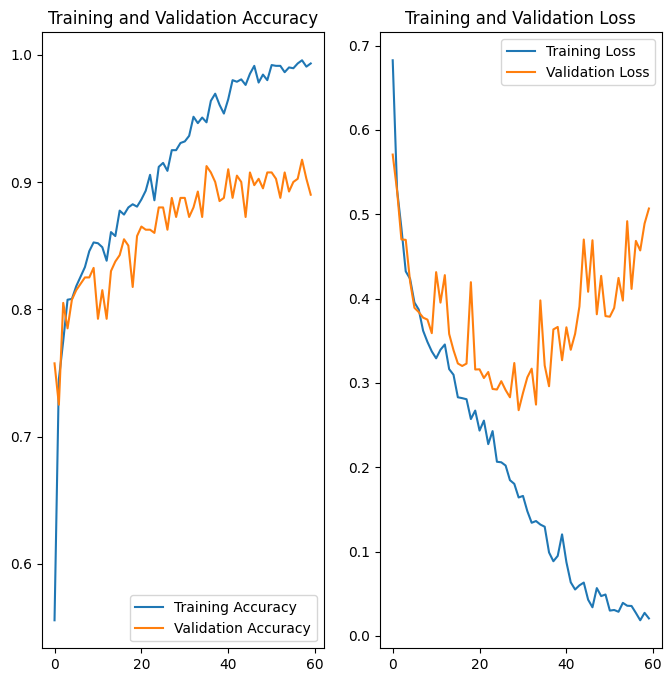

In [35]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Findings :
* After rebalance/resampling of the data (that gave equal proportion of data )and raised the accuray of the model to 90%. This addressed the low accurty problem.

*  overfitting probelm is adressed and now difference between train and val set is nearly 8-9% diff. 

* with these results it's conclusive that current module with rebalanced data is the best module.


# Evaluation.

In [42]:
#Create a file to save models
top_model_weights_path = '/kaggle/working/best_cnn_model.weights.h5'
model.save_weights(top_model_weights_path)


In [43]:
(eval_loss, eval_accuracy) = model.evaluate(test_ds, batch_size=batch_size, \
                                            verbose=1)

19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 161ms/step - accuracy: 0.8307 - loss: 0.8897


W0000 00:00:1714081784.064448     115 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [44]:
print("[INFO] accuracy: {:.2f}%".format(eval_accuracy * 100)) 
print("[INFO] Loss: {}".format(eval_loss)) 

[INFO] accuracy: 83.84%
[INFO] Loss: 0.8000844120979309
